## baseline lightning trainer notebook

Created on: Wednesday March 16th, 2022  
Created by: Jacob Alexander Rose  

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
from pathlib import Path
from icecream import ic
from rich import print as pp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pytorch_lightning as pl
# from torchvision import transforms as T
# import torchmetrics
import argparse

import wandb
import matplotlib.pyplot as plt

from hydra.experimental import compose, initialize, initialize_config_dir
import hydra
from omegaconf import DictConfig, OmegaConf
from typing import *
default_reader = None

from imutils.ml.models.pl import classifier
from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer
# from imutils.big.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.data.datamodule import *
from imutils.ml.utils.etl_utils import ETL
import imutils

# from dataclasses import dataclass, asdict, replace
# from typing import *
# from omegaconf import DictConfig, OmegaConf

Importing imutils


In [9]:
# ds = ExtantLeavesDataset(label_col='genus')

dm = ExtantLeavesDataModule(label_col='genus')
# dm = Herbarium2022DataModule(label_col='genus')

self.transform_cfg:


{'preprocess': {'train': {'resize': 512}, 'val': {'resize': 256}, 'test': {'resize': 256}}, 
'batch_transform': {'train': {'random_resize_crop': 224}, 'val': {'center_crop': 224}, 
'test': {'center_crop': 224}}, 'normalize': [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 13032
    num_batches: 102
    self.num_classes: 273
    self.batch_size: 128
ic| subset: 'val'
    num_samples: 5214
    num_batches: 41
    self.num_classes: 273
    self.batch_size: 128
ic| subset: 'test'
    num_samples: 7821
    num_batches: 62
    self.num_classes: 273
    self.batch_size: 128


In [10]:
dm.get_cfg()

ExtantLeavesDataModuleConfig(catalog_dir='/media/data_cifs/projects/prj_fossils/users/jacob/data/leavesdb-v1_1/extant_leaves_family_3_512/splits/splits=(0.5,0.2,0.3)', label_col='genus', splits=(0.5, 0.2, 0.3), shuffle=True, seed=14, batch_size=128, num_workers=16, pin_memory=True, persistent_workers=False, transform_cfg={'preprocess': {'train': {'resize': 512}, 'val': {'resize': 256}, 'test': {'resize': 256}}, 'batch_transform': {'train': {'random_resize_crop': 224}, 'val': {'center_crop': 224}, 'test': {'center_crop': 224}}, 'normalize': [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]}, remove_transforms=False)

In [11]:
ds = dm.train_dataset

ds.cfg

ds = dm.val_dataset

ds.cfg

ds = dm.test_dataset

ds.cfg

ExtantLeavesDatasetConfig(catalog_dir='/media/data_cifs/projects/prj_fossils/users/jacob/data/leavesdb-v1_1/extant_leaves_family_3_512/splits/splits=(0.5,0.2,0.3)', subset='train', label_col='genus', x_col='path', y_col='y', id_col='catalog_number', splits=(0.5, 0.2, 0.3), shuffle=True, seed=14)

ExtantLeavesDatasetConfig(catalog_dir='/media/data_cifs/projects/prj_fossils/users/jacob/data/leavesdb-v1_1/extant_leaves_family_3_512/splits/splits=(0.5,0.2,0.3)', subset='val', label_col='genus', x_col='path', y_col='y', id_col='catalog_number', splits=(0.5, 0.2, 0.3), shuffle=True, seed=14)

ExtantLeavesDatasetConfig(catalog_dir='/media/data_cifs/projects/prj_fossils/users/jacob/data/leavesdb-v1_1/extant_leaves_family_3_512/splits/splits=(0.5,0.2,0.3)', subset='test', label_col='genus', x_col='path', y_col='y', id_col='catalog_number', splits=(0.5, 0.2, 0.3), shuffle=True, seed=14)

In [30]:
# def find_data_splits_dir(source_dir: str,
# 						 train_size: float=0.7) -> Path:
#     """
#     Given a base path of `source_dir`, construct the correct data split dir path using chosen train_size.
#     """

#     if f"train_size-{train_size:.1f}" in str(source_dir):
#         return source_dir
#         # print(f"Returning in 1st block -> source_dir: {source_dir}")
    
#     out_dir = Path(source_dir)
    
#     train_split_subdir = out_dir.parts[-1] 
#     if train_split_subdir.split("-")[0] == "train_size":
#         if train_split_subdir.split("-")[0] != f"{train_size:.1f}":
#             return Path(*out_dir.parts[:-1], f"train_size-{train_size:.1f}")
#         return out_dir

#     if "splits" not in out_dir.parts[-2:]:
#         out_dir = out_dir / "splits"

#     out_dir = out_dir / f"train_size-{train_size:.1f}"
#     return out_dir


# # print(f"Returning in last block -> out_dir: {out_dir}")

# source_dir='/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/catalogs/splits/train_size-0.8'
# train_size=0.7

# result = find_data_splits_dir(source_dir=source_dir,
#                      train_size=train_size)

# print(result)

## Load test config

In [11]:
run_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45"

# os.listdir(run_dir)
# os.chdir(run_dir)
# run.save(glob_str="./ckpts/*")

TypeError: save() got an unexpected keyword argument 'glob_str'

In [3]:
# run_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45"

run_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/"

ckpt_dir = os.path.join(run_dir, "ckpts")

top_k = 3

ckpt_paths = [os.path.join(ckpt_dir, f) for f in sorted(os.listdir(ckpt_dir))[-top_k:]]
paths = []
for d in ckpt_paths:
    if os.path.isdir(d):
        for f in sorted(os.listdir(d)):
            paths.append(os.path.join(d, f))
    else:
        paths.append(d)
paths

['/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=31-val_loss=1.270-val_macro_F1=0.738/model_weights.ckpt',
 '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=32-val_loss=1.277-val_macro_F1=0.739/model_weights.ckpt',
 '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/last.ckpt']

In [10]:
# run_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45"

run_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/"

ckpt_dir = os.path.join(run_dir, "ckpts")

top_k = 3

ckpt_paths = [os.path.join(ckpt_dir, f) for f in sorted(os.listdir(ckpt_dir))[-top_k:]]
paths = []
for d in ckpt_paths:
    if os.path.isdir(d):
        for f in sorted(os.listdir(d)):
            paths.append(os.path.join(d, f))
    else:
        paths.append(d)
paths

['/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=26-val_loss=1.281-val_macro_F1=0.733/model_weights.ckpt',
 '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/epoch=27-val_loss=1.290-val_macro_F1=0.734/model_weights.ckpt',
 '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/last.ckpt']

In [4]:
import os
import wandb

os.environ["WANDB_PROJECT"]="herbarium2022"
!set | grep WANDB


artifact = wandb.Artifact("model-weights", "checkpoints")
# Add Files and Assets to the artifact using 
# `.add`, `.add_file`, `.add_dir`, and `.add_reference`
artifact.add_dir(ckpt_dir)
# artifact.add_file(ckpt_path)
artifact.save()




# api = wandb.Api()
# run = api.run("herbarium2022/37r673ke")
# run.upload_file(ckpt_path)
# for path in ckpt_paths:
#     print(f"Uploading file to wandb: {path}")
#     run.upload_file(path)
# run = wandb.init(project=PROJECT_NAME, resume=True)
# run.finish

BASH_EXECUTION_STRING='set | grep WANDB'
WANDB_API_KEY=4da22f6127e7f77527340ffede80688f6e9fb597
WANDB_CACHE_DIR=/media/data/jacob/wandb_cache
WANDB_ENTITY=jrose
WANDB_PROJECT=herbarium2022


wandb: Adding directory to artifact (/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts)... Done. 15.4s
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [6]:
%load_ext filprofiler

import psutil
from rich import print as pp
print(f"RAM memory % used: {psutil.virtual_memory()[2]}")

In [2]:
from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
import sys

Importing imutils


In [3]:
%%filprofile

root_dir = "/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/catalogs"

ds = Herbarium2022Dataset(catalog_dir=root_dir, image_reader="PIL")

ds

=fil-profile= WARNING: Fil does not (yet) support tracking memory in subprocesses.
=fil-profile= Preparing to write to fil-result/tmpqvlwf71t
=fil-profile= Wrote flamegraph to "fil-result/tmpqvlwf71t/peak-memory.svg"
=fil-profile= Wrote flamegraph to "fil-result/tmpqvlwf71t/peak-memory-reversed.svg"


In [12]:
pp(dict(ds.df.iloc[0]))

path = ds.df.path[0]

{
    'idx': 800061,
    'Species': 'Trifolium fucatum',
    'path': '/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-
512/train_images/147/56/14756__047.jpg',
    'y': 14752,
    'category_id': 14756,
    'genus_id': 2443,
    'institution_id': 36,
    'image_id': '14756__047',
    'file_name': '147/56/14756__047.jpg',
    'scientificName': 'Trifolium fucatum Lindl.',
    'family': 'Fabaceae',
    'genus': 'Trifolium',
    'species': 'fucatum',
    'collectionCode': 'NY'
}

In [25]:
from PIL import Image
# %%filprofile
# img_bytes = img.tobytes()

%%filprofile

def display_obj_size(obj):
    img_mem = sys.getsizeof(obj)
    # img_mem = sys.getsizeof(img_bytes)
    print("img size in memory:")
    print(f"- {img_mem:,} bytes")
    print(f"- {img_mem/1000:,} kb")
    print(f"- {img_mem/1000/1000:,} Mb")
    
    
display_obj_size(img.tobytes())

In [35]:
import numpy as np
import cv2

In [76]:
%%filprofile

take_k = 50
paths = ds.df.path[:take_k]

imgs = []
for i, path in enumerate(paths):
    # img = Image.open(path)
    # img = np.asarray(img)
    with open(path,"rb") as f:
        # imgs.append(f.read())
        img_enc = f.read()
        
    img_buffer = np.frombuffer(img_enc, np.uint8)
    dec_img = cv2.imdecode(img_buffer, cv2.IMREAD_ANYCOLOR)
    img = dec_img[:,:,::-1]
        
    # img = cv2.imread(path)
    # if i < 3:
        # display_obj_size(img.tobytes())
    imgs.append(img)
    # break
    
imgs = np.stack(imgs)
# print(imgs.shape)

=fil-profile= Preparing to write to fil-result/tmprfhfp9fl
=fil-profile= Wrote flamegraph to "fil-result/tmprfhfp9fl/peak-memory.svg"
=fil-profile= Wrote flamegraph to "fil-result/tmprfhfp9fl/peak-memory-reversed.svg"


In [77]:
imgs.shape

(50, 512, 512, 3)

In [48]:
display_obj_size(imgs[0])

img size in memory:
- 28,187 bytes
- 28.187 kb
- 0.028187 Mb


In [66]:
# img_buffer = imgs[2]
img_enc = imgs[2]


# img_enc = base64.b64decode(img_b64_enc)
img_buffer = np.frombuffer(img_enc, np.uint8)
dec_img = cv2.imdecode(img_buffer, cv2.IMREAD_ANYCOLOR)
img = img[:,:,::-1]

In [71]:
dec_img.shape

(512, 512, 3)

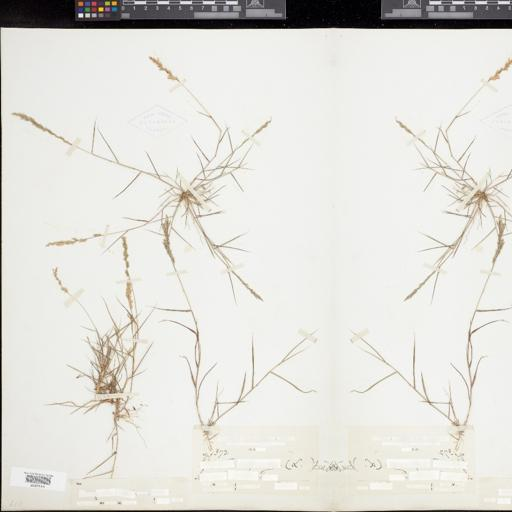

In [73]:
Image.fromarray(dec_img[:,:,::-1])

In [54]:
dec_img = cv2.imdecode(imgs[0], cv2.IMREAD_ANYCOLOR)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'imdecode'
> Overload resolution failed:
>  - buf is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'buf'


In [51]:
img = cv2.imdecode(imgs[0], "jpeg")

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'imdecode'
> Overload resolution failed:
>  - buf is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'buf'


In [53]:
# imgs[0]

In [47]:
len(imgs[0])

28154

In [46]:
type(imgs[0])

bytes

In [44]:
stream = imgs[0]
stream.read

In [42]:
imgs[0].read

dir(imgs[0])

In [31]:
img.shape

(512, 512, 3)

In [8]:
ds.y_col = "scientificName"

In [9]:
%%filprofile
sample = ds[0]

=fil-profile= Preparing to write to fil-result/tmpewm_9wwk
=fil-profile= Wrote flamegraph to "fil-result/tmpewm_9wwk/peak-memory.svg"
=fil-profile= Wrote flamegraph to "fil-result/tmpewm_9wwk/peak-memory-reversed.svg"


In [11]:
%%filprofile

img = sample[0]
label = sample[1]

print(label)
img

Trifolium fucatum Lindl.


=fil-profile= Preparing to write to fil-result/tmpdk8pbarg
=fil-profile= Wrote flamegraph to "fil-result/tmpdk8pbarg/peak-memory.svg"
=fil-profile= Wrote flamegraph to "fil-result/tmpdk8pbarg/peak-memory-reversed.svg"


In [27]:
%memit img_mem = sys.getsizeof(img.tobytes())

print("img size in memory:")
print(f"- {img_mem:,} bytes")
print(f"- {img_mem/1000:,} kb")
print(f"- {img_mem/1000/1000:,} Mb")

UsageError: Line magic function `%memit` not found.


In [ ]:
from io import BytesIO
img_file = BytesIO()
img.save(img_file, 'png')
img_file_size_png = img_file.tell()
img_file = BytesIO()
img.save(img_file, 'jpeg')
img_file_size_jpeg = img_file.tell()
print("img_file_size png: ", img_file_size_png)
print("img_file_size jpeg: ", img_file_size_jpeg)

In [24]:


import StringIO
output = StringIO.StringIO()
image_output.save(output, 'PNG') #a format needs to be provided
contents = output.getvalue()
output.close()

image_filesize = len(contents)

In [37]:
ram_info = psutil.virtual_memory()

for name, quantity in ram_info._asdict().items():
    if name == "percent":
        print(f"{name}: {quantity/100:.2%}")
    else:
        print(f"{name}: {quantity/1000/1000/1000:2,} GB")
        print(f"{name}: {quantity/1000/1000:2,} MB")
        print(f"{name}: {quantity/1000:.2e} kb")
    print("="*20)

# pp(ram_info)

# total, avail, perc = ram_info[:3]

total: 270.16255488 GB
total: 270,162.55488 MB
total: 2.70e+08 kb
available: 204.895768576 GB
available: 204,895.768576 MB
available: 2.05e+08 kb
percent: 24.20%
used: 52.103389184 GB
used: 52,103.389184 MB
used: 5.21e+07 kb
free: 1.262485504 GB
free: 1,262.485504 MB
free: 1.26e+06 kb
active: 120.82228019200001 GB
active: 120,822.280192 MB
active: 1.21e+08 kb
inactive: 136.644784128 GB
inactive: 136,644.784128 MB
inactive: 1.37e+08 kb
buffers: 1.749958656 GB
buffers: 1,749.958656 MB
buffers: 1.75e+06 kb
cached: 215.04672153600004 GB
cached: 215,046.72153600003 MB
cached: 2.15e+08 kb
shared: 11.269382144 GB
shared: 11,269.382144 MB
shared: 1.13e+07 kb
slab: 8.159367168 GB
slab: 8,159.367168 MB
slab: 8.16e+06 kb


In [12]:
print(f"{0.000012079806881608064:e}")

1.207981e-05


In [13]:
print(f"{0.0000027673238836757465:e}")

2.767324e-06


In [14]:
print(f"{0.000012079806881608064/0.0000027673238836757465:e}")

4.365158e+00


In [16]:
print(f"{0.0000027673238836757465/0.000012079806881608064}")

0.22908676527677738


In [2]:
!wandb sync --id "37r673ke" -p "herbarium2022" -e "jrose" --include-online "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-29/05-31-45/ckpts/*"

'running'

In [55]:
(671817 + 167955)

train = 671817 / 24 / 4
val = 167955 / 24 / 4

train
val
train+ val

1/1.10
1/1.3
1/1.6

24/1.10
24/1.3
24/1.6

(24/1.10)**-1
(24/1.3)**-1
(24/1.6)**-1

24/1.62

In [3]:
config_path = os.path.dirname(imutils.ml.BASE_ML_CONF_PATH)
config_name = os.path.basename(imutils.ml.BASE_ML_CONF_PATH)

cfg = ETL.init_structured_config(config_name = config_name,
                                 config_path = config_path,
                                 job_name = "demo",
                                 dataclass_type= None,
                                 overrides = ["data.datamodule.num_workers=4",
                                              "data/datamodule@data=herbarium2022-res_512_datamodule",
                                              # "train.pl_trainer.gpus=4",
                                              "train.pl_trainer.accelerator=gpu",
                                              "model_cfg.backbone.name=resnext50_32x4d"],
                                              # "model_cfg.backbone.name=resnet_50"],
                                              # "model_cfg.backbone.name=xcit_large_24_p16_224"],
                                              # "model_cfg.backbone.name=resnetv2_101x1_bitm"],
                                             # "model_cfg.backbone.name=resnetv2_50"], 
                                 cfg = None)




In [4]:
OmegaConf.set_struct(cfg, False)
# Hydra run directory
try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    print(e)
    hydra_dir = os.getcwd()


hydra_dir = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17"


if not cfg.get("hydra"):
    cfg.update({"hydra":{"run":{"dir":hydra_dir}},
                "run_output_dir":hydra_dir})
    print(cfg.hydra.run.dir)

print(OmegaConf.to_yaml(cfg.hydra))#, resolve=True, sort_keys=True))

name 'HydraConfig' is not defined
/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17
run:
  dir: /media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17



## Instantiate experiment ingredients with config

In [5]:
from icecream import ic

# OmegaConf.register_new_resolver("int", int)

if cfg.train.deterministic:
    pl.seed_everything(cfg.train.random_seed)

if cfg.train.pl_trainer.fast_dev_run:
    hydra.utils.log.info(
        f"Debug mode <{cfg.train.pl_trainer.fast_dev_run}>. "
        f"Forcing debugger friendly configuration!"
    )
    cfg.train.pl_trainer.gpus = 0
    cfg.data.datamodule.num_workers = 0

try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    hydra_dir = os.getcwd()

hydra.utils.log.info(f"Instantiating <{cfg.data.datamodule._target_}>")
datamodule: pl.LightningDataModule = hydra.utils.instantiate(
    cfg.data.datamodule, _recursive_=False
)
datamodule.setup()

self.transform_cfg:


{'preprocess': {'train': {'resize': 256}, 'val': {'resize': 256}, 'test': {'resize': 256}}, 
'batch_transform': {'train': {'random_resize_crop': 224}, 'val': {'center_crop': 224}, 
'test': {'center_crop': 224}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 256, 'resolution': 224}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 671817
    num_batches: 5249
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'val'
    num_samples: 167955
    num_batches: 1313
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'test'
    num_samples: 210407
    num_batches: 1644
    self.num_classes: 15501
    self.batch_size: 128


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from imutils.ml.utils.toolbox.nn.functional import sequence2np

from imutils.ml.utils.toolbox.nn.loss import CBCrossEntropyLoss



In [8]:
targets = datamodule.train_dataset.df.y

loss_func = CBCrossEntropyLoss(targets=targets,
                               beta=0.0,
                               reduction="mean")

assert np.all(loss_func.weights.numpy()==1.0)

In [18]:
targets = datamodule.train_dataset.df.y

loss_func = CBCrossEntropyLoss(targets=targets,
                               beta=0.99,
                               reduction="mean")

# np.all(loss_func.weights.numpy()==1.0)

False

In [25]:
w_max = loss_func.weights.numpy().max()
w_min = loss_func.weights.numpy().min()

w_sum = loss_func.weights.numpy().sum()
w_count = len(loss_func.weights)

print(f"w_max: {w_max:.5f}","\n",
      f"w_min: {w_min:.5f}","\n",
      f"w_sum: {w_sum:.5f}","\n",
      f"w_count: {w_count}")

w_max: 0.25378 
 w_min: 0.02108 
 w_sum: 622.07556 
 w_count: 15501


In [48]:
w = loss_func.weights
w_max = loss_func.weights.numpy().max()
w_min = loss_func.weights.numpy().min()
w_normalized = (w - w_min) / (w_max - w_min)



for name, w in [("normalized weights", w_normalized), ("weights", loss_func.weights)]:

    w_max = w.numpy().max()
    w_min = w.numpy().min()

    w_sum = w.numpy().sum()
    w_count = len(w)

    print(f"{name}:", "\n", "="*10)
    print(f"w_max: {w_max:.5f}","\n",
          f"w_min: {w_min:.5f}","\n",
          f"w_sum: {w_sum:.5f}","\n",
          f"w_count: {w_count}", "\n")

normalized weights: 
w_max: 1.00000 
 w_min: 0.00000 
 w_sum: 1269.12549 
 w_count: 15501 

weights: 
w_max: 0.25378 
 w_min: 0.02108 
 w_sum: 622.07556 
 w_count: 15501 



In [30]:
loss_func.classes
reindex = np.argsort(loss_func.class_counts)[::-1]
reindex

array([    0,     1,     2, ..., 15498, 15499, 15500])

array([ 9740,  4556,  4422, ..., 14156, 13301, 14452])

In [35]:
ordered_class_counts = loss_func.class_counts[reindex]
ordered_class_weights = loss_func.weights.numpy()[reindex]


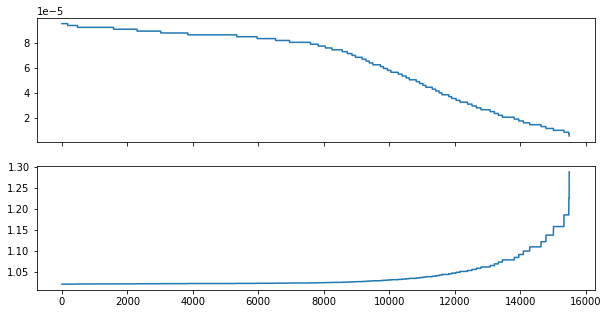

In [41]:
fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=False)
ax[0].plot(ordered_class_counts/np.sum(ordered_class_counts))
ax[1].plot(np.exp(ordered_class_weights))

In [9]:


dir(loss_func)

In [ ]:
weights = torch.tensor([9.8, 68.0, 5.3, 3.5, 10.8, 1.1, 1.4], dtype=torch.float32)
weights = weights / weights.sum()
print(weights)
weights = 1.0 / weights
weights = weights / weights.sum()
print(weights)

In [60]:
y = datamodule.train_dataset.df.y

counts_df = y.value_counts()

In [14]:
y = sequence2np(y)
classes, class_counts = np.unique(y, return_counts=True)

print(type(classes), type(class_counts))

classes

# label = 48

for label in range(15000):
    assert class_counts[label] == counts_df[label]

# plt.bar(counts_df.index, counts_df.values)

y = y.values.to_numpy()
y.shape


import numpy as np

# y = np.array(y)
y

type(y)

y.value_counts().sort_index()

In [6]:
# logging.warning("1. Before model, before trainer")
hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(cfg.model, cfg=cfg, _recursive_=False)
model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                                      loss=cfg.model_cfg.loss)
# logging.warning("2. After model, before trainer")
# ic(torch.cuda.current_device())	
# ic(torch.cuda.get_device_name(0))
wandb_logger = configure_loggers(cfg=cfg, model=model)
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train)	
hydra.utils.log.info(f"Instantiating the Trainer")
pp(OmegaConf.to_container(cfg.train.pl_trainer))
trainer = configure_trainer(cfg,
                            callbacks=callbacks,
                            logger=wandb_logger)
# logging.warning("3. After model, after trainer, before fit")
# ic(torch.cuda.current_device())
num_samples = len(datamodule.train_dataset)
num_classes = cfg.model_cfg.head.num_classes
batch_size = datamodule.batch_size #["train"]
hydra.utils.log.info("Starting training with {} classes across {} images in batches of {} images each.".format(
    num_classes,
    num_samples,
    batch_size))



Initializing weights of the model head.
input_size: (1, 3, 224, 224)


2022-03-31 07:43:06,972 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pytorch_lightning.callbacks.LearningRateMonitor>
2022-03-31 07:43:06,976 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pytorch_lightning.callbacks.early_stopping.EarlyStopping>
2022-03-31 07:43:06,983 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pytorch_lightning.callbacks.ModelCheckpoint>
2022-03-31 07:43:06,992 imutils.ml.utils.experiment_utils INFO     Instantiating callback <imutils.ml.callbacks.wandb_callbacks.WatchModelWithWandb>
2022-03-31 07:43:07,004 imutils.ml.utils.experiment_utils INFO     Instantiating callback <imutils.ml.callbacks.wandb_callbacks.UploadCheckpointsToWandbAsArtifact>
2022-03-31 07:43:07,010 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pl_bolts.callbacks.ModuleDataMonitor>


{
    '_target_': 'pytorch_lightning.Trainer',
    'fast_dev_run': False,
    'accelerator': 'gpu',
    'devices': 1,
    'precision': 16,
    'enable_model_summary': True,
    'log_every_n_steps': 15,
    'max_epochs': '${hp.max_epochs}',
    'accumulate_grad_batches': 1,
    'strategy': {
        '_target_': 'pytorch_lightning.plugins.DDPPlugin',
        'find_unused_parameters': False
    }
}

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [12]:
datamodule.test_dataset.test_transform = None

In [13]:
datamodule.test_dataset[0][0].shape

torch.Size([3, 224, 224])

In [21]:
from tqdm import tqdm

loader = datamodule.test_dataloader()
for i, batch in tqdm(enumerate(iter(loader)), total = len(loader)):
    if i > 50:
        break

  3%|██▉                                                                                          | 51/1644 [01:52<58:35,  2.21s/it]


In [26]:
128*2.21

282.88

In [23]:
64*

128

In [18]:
from PIL import Image
img = Image.open(datamodule.test_dataset.df.path.iloc[0])
img.size

(512, 512)

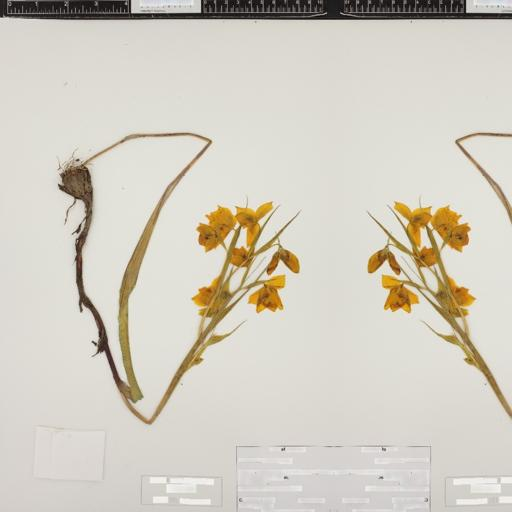

In [19]:
img

In [10]:
import meerkat as mk
# from meerkat.contrib.imagenette import download_imagenette


# dp_csv_path = datamodule.train_dataset.split_file_path
dp_csv_path = datamodule.test_dataset.split_file_path

# download_imagenette(".")
dp = mk.DataPanel.from_csv(dp_csv_path)
dp["img"] = mk.ImageColumn.from_filepaths(dp["path"],
                                          transform=datamodule.test_transform)
# dp[["scientificName", "image_id", "img"]].lz[:3]
dp[["image_id", "img"]].lz[:3]

,image_id (PandasSeriesColumn),img (ImageColumn)
0,0,"tensor([[[1.4783, 1.4783, 1.4783, ..., 1.4440, 1.4184, 1.3584], [1.4783, 1.4783, 1.4783, ..., 1.4697, 1.4440, 1.4141], [1.4783, 1.4783, 1.4783, ..., 1.4697, 1.4483, 1.4440], ..., [1.7095, 1.6881, 1.6881, ..., 1.9920, 2.0092, 2.0006], [1.7865, 1.7694, 1.7694, ..., 1.9920, 2.0092, 2.0177], [1.8764, 1.8550, 1.8550, ..., 1.9835, 2.0092, 2.0263]], [[1.2031, 1.2031, 1.2031, ..., 1.1681, 1.1418, 1.0805], [1.2031, 1.2031, 1.2031, ..., 1.1943, 1.1681, 1.1374], [1.2031, 1.2031, 1.2031, ..., 1.1943, 1.1724, 1.1681], ..., [1.8071, 1.7852, 1.7852, ..., 2.0434, 2.0259, 2.0172], [1.8859, 1.8683, 1.8683, ..., 2.0434, 2.0259, 2.0347], [1.9778, 1.9559, 1.9559, ..., 2.0347, 2.0434, 2.0434]], [[0.4788, 0.4788, 0.4788, ..., 0.4439, 0.4178, 0.3568], [0.4788, 0.4788, 0.4788, ..., 0.4701, 0.4439, 0.4134], [0.4788, 0.4788, 0.4788, ..., 0.4701, 0.4483, 0.4439], ..., [1.8295, 1.8078, 1.8078, ..., 2.0823, 2.0823, 2.0736], [1.8905, 1.8731, 1.8731, ..., 2.0823, 2.0823, 2.0910], [1.9820, 1.9603, 1.9603, ..., 2.0823, 2.0997, 2.1084]]])"
1,1,"tensor([[[1.4569, 1.4269, 1.4355, ..., 1.6453, 1.6924, 1.6838], [1.4783, 1.4783, 1.4697, ..., 1.4997, 1.5810, 1.5982], [1.8208, 1.6924, 1.4612, ..., 1.5168, 1.6196, 1.6367], ..., [1.4055, 1.3970, 1.3798, ..., 1.3156, 1.3156, 1.3156], [1.3670, 1.3499, 1.3627, ..., 1.2985, 1.2985, 1.2985], [1.3242, 1.3584, 1.3970, ..., 1.2899, 1.2899, 1.2899]], [[1.4963, 1.4657, 1.4744, ..., 1.7677, 1.8158, 1.7896], [1.5182, 1.5182, 1.5095, ..., 1.6276, 1.7108, 1.7108], [1.8683, 1.7370, 1.5007, ..., 1.6276, 1.7327, 1.7458], ..., [1.5488, 1.5401, 1.5226, ..., 1.3519, 1.3519, 1.3519], [1.5095, 1.4919, 1.5051, ..., 1.3344, 1.3344, 1.3344], [1.4526, 1.4832, 1.5226, ..., 1.3256, 1.3256, 1.3256]], [[1.3982, 1.3677, 1.3764, ..., 1.7511, 1.7990, 1.7903], [1.4200, 1.4200, 1.4112, ..., 1.5812, 1.6640, 1.6901], [1.7773, 1.6378, 1.4025, ..., 1.5812, 1.6858, 1.7119], ..., [1.7206, 1.7206, 1.7032, ..., 1.2544, 1.2544, 1.2544], [1.6553, 1.6378, 1.6509, ..., 1.2370, 1.2370, 1.2370], [1.5332, 1.5768, 1.6160, ..., 1.2282, 1.2282, 1.2282]]])"
2,2,"tensor([[[1.5810, 1.6067, 1.6153, ..., 1.6453, 1.7052, 1.6709], [1.6281, 1.6410, 1.6367, ..., 1.6067, 1.6410, 1.6752], [1.6110, 1.6367, 1.6410, ..., 1.8122, 1.7523, 1.6881], ..., [1.6024, 1.6067, 1.5982, ..., 1.9064, 1.9193, 1.9278], [1.5725, 1.5896, 1.5682, ..., 1.8936, 1.9064, 1.9150], [1.5511, 1.5639, 1.5554, ..., 1.9021, 1.9150, 1.9235]], [[1.7108, 1.7370, 1.7458, ..., 1.7677, 1.8683, 1.8596], [1.7589, 1.7721, 1.7677, ..., 1.7195, 1.8027, 1.8771], [1.7414, 1.7677, 1.7721, ..., 1.9296, 1.9121, 1.8902], ..., [1.7502, 1.7546, 1.7458, ..., 2.0259, 2.0390, 2.0478], [1.7195, 1.7370, 1.7152, ..., 2.0128, 2.0259, 2.0347], [1.6933, 1.7064, 1.6977, ..., 2.0128, 2.0259, 2.0347]], [[1.6727, 1.6988, 1.7075, ..., 1.6596, 1.7990, 1.8383], [1.7119, 1.7250, 1.7206, ..., 1.5942, 1.7337, 1.8470], [1.6945, 1.7206, 1.7250, ..., 1.8121, 1.8557, 1.8600], ..., [1.6509, 1.6553, 1.6465, ..., 1.9080, 1.9210, 1.9298], [1.6204, 1.6378, 1.6160, ..., 1.8949, 1.9080, 1.9167], [1.6073, 1.6204, 1.6117, ..., 1.8731, 1.8818, 1.8905]]])"


In [13]:
dp["img"][3].shape

torch.Size([3, 224, 224])

In [15]:


import numpy as np
blue_col = dp.map(
    lambda x: np.array(x["img"])[2, :, :].mean(), 
    # lambda x: np.array(x["img"])[:, :, 2].mean(), 
    pbar=True, 
    num_workers=2
)
dp["avg_blue"] = blue_col  # add the intensities as a new column in the `DataPanel` 

In [6]:
dp

meerkat.columns.image_column.ImageColumn

In [7]:
type(dp["img"][0])

PIL.Image.Image

In [9]:
# dir(dp["img"].data)
dp["img"].data

,(PandasSeriesColumn)
0,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/test_images/000/test-000000.jpg
1,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/test_images/000/test-000001.jpg
2,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/test_images/000/test-000002.jpg
3,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/test_images/000/test-000003.jpg
4,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/test_images/000/test-000004.jpg
...,...
210402,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/test_images/223/test-223645.jpg
210403,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/test_images/223/test-223646.jpg
210404,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/test_images/223/test-223647.jpg
210405,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/test_images/223/test-223648.jpg


In [23]:
# 1. Define the forward hook
class ActivationExtractor:
    """Extracting activations a targetted intermediate layer"""

    def __init__(self):
        self.activation = None

    def forward_hook(self, module, input, output):
        self.activation = output

# model.setup()
# 2. Register the forward hook
extractor = ActivationExtractor()
model.net.backbone.layer4.register_forward_hook(extractor.forward_hook);

In [24]:


import torch

import meerkat.ml as mkml
# 1. Move the model to GPU
model.to(0).eval()

# 2. Define a function that runs a forward pass over a batch 
@torch.no_grad()
def predict(batch: mk.DataPanel):
    input_col: mk.TensorColumn = batch["img"] 
    x: torch.Tensor = input_col.data.to(0)  # We get the underlying torch tensor with `data` and move to GPU 
    out: torch.Tensor = model(x)  # Run forward pass

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": torch.softmax(out, axis=-1).cpu(),
        "activation": mkml.EmbeddingColumn(extractor.activation.mean(dim=[-1,-2]).cpu())
    }



valid_dp = dp.lz[:100]
# 3. Apply the update. Note that the `predict` function operates on batches, so we set 
# `is_batched_fn=True`. Also, the `predict` function only accesses the "input" column, by 
# specifying that here we instruct update to only load that one column and skip others 
valid_dp = valid_dp.update(
    function=predict,
    is_batched_fn=True,
    batch_size=32,
    input_columns=["img"], 
    pbar=True
)

In [17]:
# dp["img"]
updated_dp

NameError: name 'updated_dp' is not defined

In [8]:
pp(OmegaConf.to_container(model.cfg, resolve=True))

{
    'core': {
        'name': 'herbarium2022__resnext50_32x4d',
        'version': '0.0.1',
        'tags': ['herbarium2022', 'kaggle']
    },
    'hp': {'preprocess_size': 256, 'resolution': 224, 'num_channels': 3},
    'seed': 42,
    'run_output_dir': 
'/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17',
    'checkpoint_dir': '/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022
-03-24/07-35-17/ckpts',
    'data': {
        'datamodule': {
            '_target_': 'imutils.ml.data.datamodule.Herbarium2022DataModule',
            'name': 'herbarium2022',
            'catalog_dir': '/media/data/jacob/GitHub/image-utils/imutils/big/data',
            'label_col': 'scientificName',
            'train_size': 0.7,
            'shuffle': True,
            'seed': 14,
            'batch_size': 128,
            'num_workers': 4,
            'pin_memory': True,
            'transform_cfg': {
                'preprocess_size': 256,
                'resolution': 224,
                'preprocess': {
                    'train': {'resize': 256},
                    'val': {'resize': 256},
                    'test': {'resize': 256}
                },
                'batch_transform': {
                    'random_flips': False,
                    'train': {'random_resize_crop': 224},
                    'val': {'center_crop': 224},
                    'test': {'center_crop': 224}
                },
                'normalize': [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
            },
            'remove_transforms': False,
            'image_reader': 'default',
            'datasets': {
                'herbarium2022': {
                    'train': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'train',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': True,
                        'seed': 14
                    },
                    'val': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'val',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': False,
                        'seed': 14
                    },
                    'test': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'train',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': True,
                        'seed': 14
                    }
                }
            }
        }
    },
    'model_cfg': {
        '_target_': 'imutils.ml.models.pl.classifier.LitClassifier',
        'backbone': {
            'model_repo': 'timm',
            'name': 'resnext50_32x4d',
            'pretrained': True,
            'freeze_backbone': True
        },
        'head': {
            'num_classes': 15501,
            'pool_size': 1,
            'pool_type': 'avg',
            'head_type': 'linear',
            'hidden_size': 512,
            'dropout_p': 0.3
        },
        'name': 'resnext50_32x4d',
        'loss': {'_target_': 'torch.nn.CrossEntropyLoss'},
        'resolution': 224,
        'num_channels': 3,
        'input_shape': [3, 224, 224]
    },
    'optim': {
        'optimizer': {
            '_target_': 'torch.optim.Adam',
            'lr': 0.001,
            'betas': [0.9, 0.999],

In [9]:
# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=14-val_loss=2.521-val_F1=0.443.ckpt"

model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();


Initializing weights of the model head.
input_size: (1, 3, 224, 224)


In [ ]:
results = []

for batch in iter(test_dataloader):
    x, y, metadata = batch
    x.to(model.device)
    image_ids = metadata['image_id']
    
    y_logits = model.predict_step(x)
    
    results.append({"image_id": image_ids,
                    "y_logits: y_logits"})

In [10]:
pp(OmegaConf.to_container(model.cfg, resolve=True))

{
    'core': {
        'name': 'herbarium2022__resnext50_32x4d',
        'version': '0.0.1',
        'tags': ['herbarium2022', 'kaggle']
    },
    'hp': {'preprocess_size': 256, 'resolution': 224, 'num_channels': 3},
    'seed': 42,
    'run_output_dir': './hydra_experiments/2022-03-24/07-35-17',
    'checkpoint_dir': './hydra_experiments/2022-03-24/07-35-17/ckpts',
    'data': {
        'datamodule': {
            '_target_': 'imutils.ml.data.datamodule.Herbarium2022DataModule',
            'name': 'herbarium2022',
            'catalog_dir': '/media/data/jacob/GitHub/image-utils/imutils/big/data',
            'label_col': 'scientificName',
            'train_size': 0.7,
            'shuffle': True,
            'seed': 14,
            'batch_size': 64,
            'num_workers': 4,
            'pin_memory': True,
            'transform_cfg': {
                'preprocess_size': 256,
                'resolution': 224,
                'preprocess': {
                    'train': {'resize': 256},
                    'val': {'resize': 256},
                    'test': {'resize': 256}
                },
                'batch_transform': {
                    'random_flips': False,
                    'train': {'random_resize_crop': 224},
                    'val': {'center_crop': 224},
                    'test': {'center_crop': 224}
                },
                'normalize': [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
            },
            'remove_transforms': False,
            'image_reader': 'default',
            'datasets': {
                'herbarium2022': {
                    'train': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'train',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': True,
                        'seed': 14
                    },
                    'val': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'val',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': False,
                        'seed': 14
                    },
                    'test': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'train',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': True,
                        'seed': 14
                    }
                }
            }
        }
    },
    'model_cfg': {
        '_target_': 'imutils.ml.models.pl.classifier.LitClassifier',
        'backbone': {
            'model_repo': 'timm',
            'name': 'resnext50_32x4d',
            'pretrained': False,
            'freeze_backbone': False
        },
        'head': {
            'num_classes': 15501,
            'pool_size': 1,
            'pool_type': 'avg',
            'head_type': 'linear',
            'hidden_size': 512,
            'dropout_p': 0.3
        },
        'name': 'resnext50_32x4d',
        'loss': {'_target_': 'torch.nn.CrossEntropyLoss'},
        'resolution': 224,
        'num_channels': 3,
        'input_shape': [3, 224, 224]
    },
    'optim': {
        'optimizer': {
            '_target_': 'torch.optim.Adam',
            'lr': 0.002,
            'betas': [0.9, 0.999],
            'eps': 1e-08,
            'weight_decay': 1e-05
        },
        'exclude_bn_b

In [13]:
# dir()

In [ ]:
results = {}

results['val'] = trainer.validate(model, datamodule=datamodule)

pp(results['val'])

initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jrose (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please r

Output()

/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/pytorch_lightning/utilities
/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The 
batch size we found is 256. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.
  warning_cache.warn(

/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/pytorch_lightning/utilities
/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The 
batch size we found is 28. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.
  warning_cache.warn(

--------------------------------------------------------------------------------

DATALOADER:0 VALIDATE RESULTS

In [8]:
dir(model)

['CHECKPOINT_HYPER_PARAMS_KEY',
 'CHECKPOINT_HYPER_PARAMS_NAME',
 'CHECKPOINT_HYPER_PARAMS_TYPE',
 'T_destination',
 '_DeviceDtypeModuleMixin__update_properties',
 '_LightningModule__auto_choose_log_on_epoch',
 '_LightningModule__auto_choose_log_on_step',
 '_LightningModule__check_allowed',
 '_LightningModule__check_not_nested',
 '_LightningModule__to_tensor',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__jit_unused_properties__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_apply_batch_transfer_handler',
 '_auto_collect_arguments',
 '_automatic_optimization',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_cu

In [6]:
trainer.fit(model=model, datamodule=datamodule)

name 'HydraConfig' is not defined
self.transform_cfg:


{'preprocess': {'train': {'resize': 256}, 'val': {'resize': 256}, 'test': {'resize': 256}}, 
'batch_transform': {'train': {'random_resize_crop': 224}, 'val': {'center_crop': 224}, 
'test': {'center_crop': 224}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 256, 'resolution': 224}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 587840
    num_batches: 4593
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'val'
    num_samples: 251932
    num_batches: 1969
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'test'
    num_samples: 210407
    num_batches: 1644
    self.num_classes: 15501
    self.batch_size: 128


In [17]:
from imutils.ml.utils.model_utils import log_model_summary

model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                              loss=cfg.model_cfg.loss)

print(OmegaConf.to_yaml(cfg.model_cfg, resolve=True, sort_keys=True))

# print(OmegaConf.to_yaml(cfg, resolve=True, sort_keys=True))
# print(OmegaConf.to_yaml(cfg, resolve=True, sort_keys=True))
# print(cfg['data']['datamodule']['transform_cfg'])

type(cfg.model_cfg.input_shape)
type(OmegaConf.to_container(cfg.model_cfg.input_shape, resolve=True)[0])

Initializing weights of the model head.
input_size: (1, 3, 224, 224)
_target_: imutils.ml.models.pl.classifier.LitClassifier
backbone:
  freeze_backbone: false
  model_repo: timm
  name: resnext50_32x4d
  pretrained: true
head:
  dropout_p: 0.3
  head_type: linear
  hidden_size: 512
  num_classes: 15501
  pool_size: 1
  pool_type: avg
input_shape:
- 3
- 224
- 224
loss:
  _target_: torch.nn.CrossEntropyLoss
name: resnext50_32x4d
num_channels: 3
resolution: 224



omegaconf.listconfig.ListConfig

int

In [ ]:
# Instantiate model
# hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(model_cfg=cfg, _recursive_=False)


from imutils.ml.utils.model_utils import log_model_summary

model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                              loss=cfg.model_cfg.loss)

print(OmegaConf.to_yaml(cfg.model_cfg, resolve=True, sort_keys=True))

# input_size = (1, 3,224,224)
# summary = log_model_summary(model=model,
#                             input_size=input_size,
#                             full_summary=True,
#                             working_dir=".",
#                             model_name=cfg.model_cfg.backbone.name,
#                             verbose=1)

from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer

# Instantiate the callbacks
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train) #OmegaConf.to_container(cfg.train, resolve=True))

model.freeze_up_to(layer=-1,
                  submodule="backbone")

# ([(n, p.requires_grad_(False)) for n, p in model.net.backbone.named_parameters()])
pp([(n, p.requires_grad) for n, p in model.net.backbone.named_parameters()])

In [11]:
# datamodule.test_dataset.df
# datamodule.train_dataset.df
import numpy as np
import torch

# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=07-val_loss=3.338-val_F1=0.313.ckpt"

ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

# ckpt = torch.load(ckpt_path)
# print(ckpt.keys())

model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();
# model.to("cpu")

# test_loader = datamodule.test_dataloader()
# batch = next(iter(test_loader))

# batch[1]#.cpu()

In [13]:
# batch[:2] = (b.cuda() for b in batch[:2])
# [b.cuda() for b in batch[:2]]

# batch[0] = batch[0].cuda()
# batch[1] = batch[1].cuda()
# x, y, metadata = batch
# x = x.to('cuda')
# y_logits = model(x)
# y_logits_top5 = torch.topk(torch.Tensor(y_logits.cpu()), k=5, dim=1)
# topk = 5
# y_logits_top5_idx = y_logits_top5.indices.numpy()
# labels_k = le.decode_topk(y_logits_top5_idx)
# datamodule.train_dataset.label_encoder.classes_
# y_pred = torch.zeros_like(y_logits_top5.indices)
# topk_labels = np.empty((128,5), dtype="O")
# for k in range(5):
#     labels_k = datamodule.train_dataset.label_encoder.inverse_transform(y_logits_top5.indices[:,k])
#     topk_labels[:,k] = labels_k

#### Dev topk predictions

In [31]:
# import numpy as np
# topk_labels = [] #np.empty((128,5), dtype="string")

# topk = 5
# y_logits_top5_idx = y_logits_top5.indices.numpy()

# y = y_logits_top5_idx#.shape[1]

# if isinstance(y, np.ndarray):
#     if y.ndim == 2:
#         topk = y.shape[1]
#     else:
#         topk = 1
# if isinstance(y, list):
#     if isinstance(y[0], np.ndarray):
#         topk = y[0].shape[0]
#     elif isinstance(y[0], list):
#         topk = len(y[0])

# for k in range(topk):
#     # labels_k = datamodule.train_dataset.label_encoder.inverse_transform(y_logits_top5.indices[:,k])
#     labels_k = le.decode(y[:,k])
#     topk_labels.append(labels_k)

In [23]:
# topk_labels = np.vstack(topk_labels).T
# topk_labels.shape

# topk_labels[:2,:]
# true_labels = le.decode(y.numpy())
# topk_labels[0]

# from sklearn import preprocessing
# encoder = preprocessing.LabelEncoder()
# encoder.fit([0,4,-2,6])
# encoder.classes_

# class_list = getattr(encoder, "classes_", [])
# class2idx = {label: idx for idx, label in enumerate(class_list)}
# print(class2idx)

In [19]:
from imutils.ml.utils.label_utils import LabelEncoder

le = LabelEncoder.from_sklearn(datamodule.train_dataset.label_encoder)
le

In [ ]:
from typing import *
from imutils.ml.utils.model_utils import log_model_summary

log_model_summary(model, input_size=(2,3,224,224))

ckpt['epoch']
ckpt['global_step']
ckpt['pytorch-lightning_version']
ckpt['hparams_name']
ckpt['hyper_parameters']

In [50]:

datamodule.test_dataset.y_col
getattr(datamodule.test_dataset.df, "y", -1)
# df = datamodule.train_dataset.df
df = pd.concat([datamodule.train_dataset.df,
                datamodule.val_dataset.df])
class_counts = df.value_counts("y")
class_counts = class_counts.reset_index(drop=False).rename(columns={0:"counts"})
num_classes = class_counts.shape[0]
above_25 = class_counts[class_counts.counts>=25]
above_10 = class_counts[class_counts.counts>=10]
above_5 = class_counts[class_counts.counts>=5]

below_5 = class_counts[class_counts.counts<5]
below_10 = class_counts[class_counts.counts<10]
below_25 = class_counts[class_counts.counts<25]

print("Min: ", min(class_counts.counts),"Max:", max(class_counts.counts))
pp(f"above_25: {above_25.shape[0]}, {above_25.shape[0] / num_classes:.4%}")
pp(f"above_10: {above_10.shape[0]}, {above_10.shape[0] / num_classes:.4%}")
pp(f"above_5: {above_5.shape[0]}, {above_5.shape[0] / num_classes:.4%}")

# pp(above_10.shape[0], above_10.shape[0] / num_classes)
# pp(above_5.shape[0], above_5.shape[0] / num_classes)

pp(f"below_5: {below_5.shape[0]}, {below_5.shape[0] / num_classes:.4%}")
pp(f"below_10: {below_10.shape[0]}, {below_10.shape[0] / num_classes:.4%}")
pp(f"below_25: {below_25.shape[0]}, {below_25.shape[0] / num_classes:.4%}")
# pp(below_10.shape[0], below_10.shape[0] / num_classes)
# pp(below_25.shape[0], below_25.shape[0] / num_classes)

In [57]:
def filter_catalog(catalog: pd.DataFrame,
                   column: str,
                   include=None,
                   exclude=None) -> pd.DataFrame:
    num_rows = catalog.shape[0]
    if isinstance(include, Sequence):
        pp(f"Including {len(include)}")
        catalog = catalog[catalog[column].apply(lambda x: x in include)]
    if isinstance(exclude, Sequence):
        pp(f"Excluding {len(exclude)}")
        
        catalog = catalog[catalog[column].apply(lambda x: x not in exclude)]

    pp(f"Input num_rows: {num_rows}")
    pp(f"Filtered num_rows: {catalog.shape[0]}, {catalog.shape[0]/num_rows:.3%}")
        
    return catalog

df = pd.concat([datamodule.train_dataset.df,
                datamodule.val_dataset.df])
                # datamodule.test_dataset.df])
class_counts = df.value_counts("y")
class_counts = class_counts.reset_index(drop=False).rename(columns={0:"counts"})
num_classes = class_counts.shape[0]
# above_20 = class_counts[class_counts.counts>=20].counts
# above_20 = above_20.values.tolist()
above_20 = None
below_20 = class_counts[class_counts.counts<40].counts
below_20 = below_20.values.tolist()
above_20_catalog = filter_catalog(catalog=df,
                                  column="y",
                                  include=above_20,
                                  exclude=below_20)
above_20_catalog

Excluding 4471

Input num_rows: 839772

Filtered num_rows: 837841, 99.770%

,index,Species,path,y,category_id,genus_id,institution_id,image_id,file_name,license,scientificName,family,genus,species,authors,collectionCode
0,800061,Trifolium fucatum,/media/data_cifs/projects/prj_fossils/data/raw...,14752,14756,2443,36,14756__047,147/56/14756__047.jpg,0,Trifolium fucatum Lindl.,Fabaceae,Trifolium,fucatum,Lindl.,NY
1,294940,Eragrostis urbaniana,/media/data_cifs/projects/prj_fossils/data/raw...,5484,5486,895,36,05486__011,054/86/05486__011.jpg,0,Eragrostis urbaniana Hitchc.,Poaceae,Eragrostis,urbaniana,Hitchc.,NY
2,546499,Osmorhiza purpurea,/media/data_cifs/projects/prj_fossils/data/raw...,10087,10091,1726,24,10091__046,100/91/10091__046.jpg,0,Osmorhiza purpurea (J.M.Coult. & Rose) Suksd.,Apiaceae,Osmorhiza,purpurea,(J.M.Coult. & Rose) Suksd.,ID
3,162934,Castilleja minor,/media/data_cifs/projects/prj_fossils/data/raw...,3088,3090,446,25,03090__061,030/90/03090__061.jpg,0,Castilleja minor (A.Gray) A.Gray,Orobanchaceae,Castilleja,minor,(A.Gray) A.Gray,IDS
4,206860,Corchorus hirsutus,/media/data_cifs/projects/prj_fossils/data/raw...,3894,3896,624,36,03896__020,038/96/03896__020.jpg,0,Corchorus hirsutus L.,Malvaceae,Corchorus,hirsutus,L.,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251927,667196,Quercus sinuata,/media/data_cifs/projects/prj_fossils/data/raw...,12301,12305,2023,13,12305__098,123/05/12305__098.jpg,0,Quercus sinuata Walter,Fagaceae,Quercus,sinuata,Walter,COLO
251928,735162,Sideroxylon lanuginosum,/media/data_cifs/projects/prj_fossils/data/raw...,13559,13563,2212,52,13563__050,135/63/13563__050.jpg,0,Sideroxylon lanuginosum Michx.,Sapotaceae,Sideroxylon,lanuginosum,Michx.,US
251929,127497,Campanula scabrella,/media/data_cifs/projects/prj_fossils/data/raw...,2464,2465,401,52,02465__029,024/65/02465__029.jpg,0,Campanula scabrella Engelm.,Campanulaceae,Campanula,scabrella,Engelm.,US
251930,359284,Gentiana clausa,/media/data_cifs/projects/prj_fossils/data/raw...,6666,6668,1021,21,06668__011,066/68/06668__011.jpg,0,Gentiana clausa Raf.,Gentianaceae,Gentiana,clausa,Raf.,GH


In [29]:
class_counts.describe()

# above_20 = class_counts[class_counts.counts>=20].counts
# above_20 = above_20.values.tolist()
# above_20 = None
below_20 = class_counts[class_counts.counts<40] # .counts

below_20.describe()

datamodule.val_dataset.df.value_counts("y")

dir(datamodule.train_dataset.df.groupby("y"))

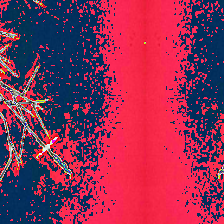

In [27]:

T.ToPILImage()(datamodule.train_dataset[1][0])

In [9]:
# from icecream import ic

# ic(9, 4)

# 16081624 / 587840

# 16081624 / 24

# 18454*24/3/60

# pp([(n, p.requires_grad) for n, p in model.net.head.named_parameters()])

# model.net.head.state_dict().keys()

# model.net["backbone"].state_dict().keys()

# import pytorch_lightning as pl

# pl.__version__

# 4593*8*2*64*2

# 2264842//128

# 9048210 / 32

# 13122*48

# datamodule.setup("fit")



train --> (num_samples: 587,840), (num_batches: 9,185)
train --> (num_samples: 587,840), (num_batches: 9,185)
val --> (num_samples: 251,932), (num_batches: 3,937)
val --> (num_samples: 251,932), (num_batches: 3,937)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


In [19]:
# val_loader = datamodule.val_dataloader()

# batch = next(iter(val_loader))

# len(batch)

# import torch
# from torch import nn
# # Single-label categorical
# x = torch.randn(10, 5)
# y = torch.randint(5, (10,))
# loss = nn.CrossEntropyLoss()(x, y)


# print(x.shape, y.shape, loss.shape)
# print(x.dtype, y.dtype, loss.dtype)

# # model

# num_samples = len(datamodule.train_dataset)
# num_batches = len(datamodule.train_dataloader())

# ic(num_samples, num_batches, num_samples/ num_batches)

# import numpy as np

# print(f"{2264842/2:,}")

# print(f"{2264842/3:,}")

# ic(num_samples * np.arange(5))

In [37]:
x, y = batch[:2]
print(x.shape, y.shape)
print(x.dtype, y.dtype)
# model

x, y = batch[:2]
logits = model(x)

loss = nn.CrossEntropyLoss()(logits, y)
print(logits.shape, logits.dtype)
print(loss.shape, loss.dtype)

from icecream import ic

a = {0, 8}
ic(a)
# datamodule.transform_cfg
# datamodule.setup_transforms(datamodule.transform_cfg)

In [46]:
# datamodule.setup_transforms(datamodule.transform_cfg)
# from imutils.ml.data.datamodule import get_default_transforms
# a = get_default_transforms(mode="train", config=datamodule.transform_cfg)

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


Compose(
    Preprocess(
  (resize_func): Resize(size=512, interpolation=bilinear)
)
    BatchTransform(
  (transforms): Sequential(
    (0): RandomPerspective(p=0.5)
    (1): RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    (2): RandomHorizontalFlip(p=0.5)
    (3): RandomVerticalFlip(p=0.5)
    (4): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )
)
)

In [12]:
import wandb
def configure_loggers(cfg):

    wandb_logger = None
    if "wandb" in cfg.logging:
        hydra.utils.log.info(f"Instantiating <WandbLogger>")
        wandb_config = cfg.logging.wandb
        wandb_logger = pl.loggers.WandbLogger(
            name=wandb_config
            .get("name", 
                           (cfg.data.datamodule.get("name") + "__" + cfg.model_cfg.name)),
            project=wandb_config.project,
            entity=wandb_config.entity,
            tags=cfg.core.tags,
            log_model=True,
        )
        hydra.utils.log.info(f"W&B is now watching <{wandb_config.watch.log}>!")
        wandb_logger.watch(
            model, log=wandb_config.watch.log, log_freq=wandb_config.watch.log_freq
        )


        hydra.utils.log.info(f"Instantiating the Trainer")
    return wandb_logger

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jrose (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [22]:
# wandb_logger = configure_loggers(cfg=cfg, model=model)
# print(wandb_logger)

# # The Lightning core, the Trainer
# trainer = pl.Trainer(
#     default_root_dir=cfg.hydra.run.dir,
#     logger=wandb_logger,
#     callbacks=callbacks,
#     deterministic=cfg.train.deterministic,
#     val_check_interval=cfg.logging.val_check_interval,
#     log_every_n_steps=10,
#     #auto_select_gpus=True,
#     # benchmark=True,
#     # accelerator=None,  # 'dp', "ddp" if args.gpus > 1 else None,
#     #plugins=[DDPPlugin(find_unused_parameters=True)],
#     **cfg.train.pl_trainer,
# )
# # num_samples = len(datamodule.train_dataset)
# num_classes = cfg.model_cfg.head.num_classes
# batch_size = datamodule.batch_size #["train"]
# hydra.utils.log.info("Starting training with {} classes and batches of {} images".format(
#     num_classes,
#     batch_size))
# # pp(OmegaConf.to_container(cfg.train.callbacks, resolve=True))
# trainer.fit(model=model, datamodule=datamodule)
# #%debug
# hydra.utils.log.info(f"Starting testing!")
# trainer.test(model=model, datamodule=datamodule)
# shutil.copytree(".hydra", Path(wandb_logger.experiment.dir) / "hydra")

## Measure time and function wrapping

In [22]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        from time import time
        start = time()
        result = func(*args, **kwargs)
        total_time = time() - start
        print(f'Elapsed time is {total_time} ms')
        
        if isinstance(result, int):
            print(f"{result}/{total_time} = {result/(total_time):.3f} samples/sec")
        return result
    return wrapper

In [13]:
# from tqdm import tqdm

@measure_time
def loop_through_dataloader(dataloader, num_batches):
    data_iter = iter(dataloader)
    for i, batch in tqdm(enumerate(data_iter), total=num_batches):
        if i > num_batches-1:
            break
    num_samples = i*len(batch[0])
    return num_samples



# train_iter = iter(datamodule.train_dataloader())
# datamodule.setup()
# dataloader = datamodule.train_dataloader()
# num_batches = 40
# loop_through_dataloader(dataloader, num_batches)
# bb = next(iter(dataloader))
# pp(datamodule.cfg)
# pp(OmegaConf.to_container(datamodule.cfg))

In [11]:
type(datamodule.cfg)

omegaconf.dictconfig.DictConfig

In [4]:

# default_cfg = DictConfig(dict(
#     catalog_dir=None,
#     label_col="scientificName",
#     train_size=0.7,
#     shuffle=True,
#     seed=14,
#     batch_size = 128,
#     num_workers = None,
#     pin_memory=True,
#     transform_cfg=None,
#     remove_transforms=False,
# ))

# from rich import print as pp

# pp(OmegaConf.to_yaml(default_cfg))

### Mock config yaml

In [ ]:
# CATALOG_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/catalog"

# datamodule = Herbarium2022DataModule(catalog_dir=CATALOG_DIR,
#                                      num_workers=4,
#                                      # image_reader=read_file_binary,
#                                      remove_transforms=True)
# datamodule.setup()

# subset = "train"
# dataset = datamodule.get_dataset(subset=subset)

# dataset.num_classes

# trainer.fit(model, datamodule)

## End

In [ ]:
# from torchvision import transforms as T
# import argparse
# from rich import print as pp

# args = argparse.Namespace(
#     preprocess={
#         "train":{
#             "resize":512
#         },
#         "val":{
#             "resize":256
#         },
#     },
#     batch_transform={
#         "train":{
#             "random_resize_crop":224
#         },
#         "val":{
#             "center_crop":224
#         },
#     normalize=(
#        [0.485, 0.456, 0.406],
#        [0.229, 0.224, 0.225]
#     )
#     }
# )
# pp(args)

# kornia_transform = nn.Sequential(
#     K.RandomHorizontalFlip(),
#     K.RandomVerticalFlip(),
#     K.RandomMotionBlur(3, 35., 0.5),
#     K.RandomRotation(degrees=45.0),
#     K.Normalize(mean=mean_std,std=mean_std)
# )

# import numpy as np
# from torch import nn
# import torch
# from albumentations.augmentations import transforms as AT

# to_tensor = T.ToTensor()

# class Preprocess(nn.Module):

#     def __init__(self, mode="train", resize=None):
#         super().__init__()
#         self.mode = mode
#         self.resize = resize        
#         self.resize_func = T.Resize(self.resize)
    
#     @torch.no_grad()  # disable gradients for effiency
#     def forward(self, x) -> torch.Tensor:
#         # x_tmp: np.ndarray = np.array(x)  # HxWxC
#         # x_out: Tensor = to_tensor(x_tmp, keepdim=True)  # CxHxW
#         if self.resize:
#             x = self.resize_func(x)

#         return x #_out.float()# / 255.0




# class BatchTransforms(nn.Module):
#     """Module to perform data augmentation using Kornia on torch tensors."""

#     def __init__(self,
#                  mode: str="train",
#                  random_resize_crop=None,
#                  center_crop=None,
#                  apply_color_jitter: bool = False,
#                  normalize = (
#                      [0,0,0],
#                      [1,1,1]
#                  )
#                 ) -> None:
#         super().__init__()
#         self.mode = mode
#         self.random_resize_crop = random_resize_crop
#         self.center_crop = center_crop
#         self._apply_color_jitter = apply_color_jitter
#         self.normalize = normalize
        
#         self.build_transforms(mode=mode)

        
#     def add_train_transforms(self, transforms=None):
        
#         transforms = transforms or []
#         # if mode == "train":
#         transforms.append(T.RandomPerspective())
#         if type(self.random_resize_crop) == int:
#             transforms.append(T.RandomResizedCrop(self.random_resize_crop))
#         transforms.extend([
#             T.RandomHorizontalFlip(),
#             T.RandomVerticalFlip()
#         ])
#         return transforms

#     def add_test_transforms(self, transforms=None):
        
#         transforms = transforms or []
#         if type(self.center_crop) == int:
#             transforms.append(T.CenterCrop(self.center_crop))
#         return transforms


#     def build_transforms(self,
#                          mode: str = "train"):
#         transforms = []
#         if mode == "train":
#             transforms = self.add_train_transforms(transforms=transforms)
#         elif mode in ["val", "test"]:
#             transforms = self.add_test_transforms(transforms=transforms)

#         transforms.extend([
# 			# T.ToTensor(),
# 			T.Normalize(*self.normalize)
#         ])

#         self.transforms = nn.Sequential(*transforms)
#         self.jitter = AT.ColorJitter(brightness=0.2,
#                                      contrast=0.2,
#                                      saturation=0.2,
#                                      hue=0.2,
#                                      always_apply=False,
#                                      p=0.5)

#     @torch.no_grad()  # disable gradients for effiency
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x_out = self.transforms(x)  # BxCxHxW
#         if self._apply_color_jitter:
#             x_out = self.jitter(x_out)
#         return x_out







# for subset in ["train","val", "test"]:
#     data = Herbarium2022Dataset(subset=subset,
#                                 label_col="scientificName",
#                                 train_size=0.7,
#                                 shuffle=(subset != "test"),
#                                 seed=14,
#                                 transform=None)

#########################################

CATALOG_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/catalog"
SHARD_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/webdataset"

# datamodule = Herbarium2022DataModule(catalog_dir=CATALOG_DIR,
#                                      batch_size=64,
#                                      num_workers=4,
#                                      image_reader=read_file_binary,
#                                      remove_transforms=True)
# datamodule.setup()


# train_dataloader = datamodule.train_dataloader()
# train_batch = next(iter(train_dataloader))
# datamodule.train_dataset.encoder.inverse_transform(train_batch[1])

# checkpoint_callback = [c for c in callbacks if isinstance(c, pl.callbacks.ModelCheckpoint)][0]
# logging.info(f"checkpoint_callback.best_model_path: {str(checkpoint_callback.best_model_path)}")
# config.system.tasks[f"task_{task_id}"].ckpt_path = checkpoint_callback.best_model_path
# checkpoint_callback.best_model_score = checkpoint_callback.best_model_score or 0.0
# logging.info(f"checkpoint_callback.best_model_score: {checkpoint_callback.best_model_score:.3f}")
# logging.info(f"[Initiating TESTING on task_{task_id}]")


# test_results = run_multitask_test(trainer=trainer,
#                               model=model,
#                               datamodule=datamodule,
#                               config=config,
#                               tasks="all")#,